# Ensemble Clustering

In this Notebook I demonstrate one of the ways of creating an ensemble clustering learner. We use similarity matrix method for creating our ensemble learner.

### Import Necessary Modules

In [401]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans, SpectralClustering, KMeans
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
%matplotlib inline

### Generate a random dataset with some clusters (set random seed for reproducibility)

In [2]:
np.random.seed(214)
X_moons, _ = make_moons(n_samples=350, noise=0.1, random_state=214)
X_blobs, _ = make_blobs(n_samples=50, centers=[[-0.5,-0.5]], cluster_std=[0.1], random_state=214)
X_noise = np.random.uniform(low=-1.5, high=2.0, size=(100,2))
X_vectors = np.vstack([X_moons, X_blobs, X_noise])

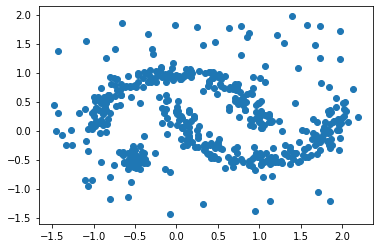

In [12]:
plt.scatter(X_vectors[:,0], X_vectors[:,1]);

### Firstly, lets do a KMeans clustering for  n_cluster = 3
- We later compare this with our ensemble
- We compare the results both with a metric and by visual inspection

In [329]:
kmeans = KMeans(n_clusters=3)
kmeans_preds = kmeans.fit_predict(X_vectors)

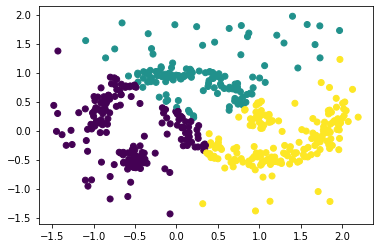

In [330]:
plt.scatter(X_vectors[:,0], X_vectors[:,1], c=kmeans_preds);

In [331]:
silhouette_score(X_vectors, kmeans_preds)

0.4122665571876057

#### silhouette score of KMeans (k=3) looks decent but visually we can see that there are 3 prominent clusters, 2 banana shaped and 1 circular and rest points are scattered.

### Let's move on and create our ensemble of KMeans
- We decide the number of base estimators we need
- We need to create a similarity matrix between the labels
- Since our labels would be discrete we will use, manhattan distance
- Note that labeling strategies of each api would be different and we would choose the similarity index accordingly. Since all our base estimators are same (both algorithms and parameters) we go on with manhattan distance.
- We pass this similarity matrix to our meta learner.
- Before passing similarity matrix to meta learner we normalize the data for ease of computation. We can further reduce computation requirements by thresholding, but that would just reduce the performance of our ensemble as we loose the information.

In [492]:
NUM_CLUSTERS = 128

In [493]:
cluster_list = NUM_CLUSTERS*[MiniBatchKMeans(n_clusters=16, batch_size=16, max_iter=50, n_init=1)]

In [510]:
def get_distance(y_preds):
    y_preds = y_preds.reshape(-1,1)
    dist = (cdist(y_preds, y_preds, "cityblock") == 0).astype(np.int32)
    return dist

In [511]:
cluster_preds = None
for cluster_instance in cluster_list:
    preds = cluster_instance.fit_predict(X_vectors)
    if cluster_preds is None:
        cluster_preds = get_distance(preds)
    cluster_preds += get_distance(preds)        

In [553]:
cluster_sim_mat = cluster_preds/cluster_preds.diagonal()

In [567]:
meta_learner = SpectralClustering(n_clusters=3, affinity="precomputed")

In [568]:
meta_preds = meta_learner.fit_predict(cluster_sim_mat)

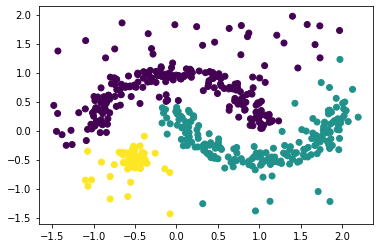

In [569]:
plt.scatter(X_vectors[:,0], X_vectors[:,1], c=meta_preds);

In [585]:
silhouette_score(X_vectors, meta_preds)

0.269376407077731

#### silhouette score of our ensemble learner is not so good compare to the single KMeans. BUT, with visual inspection we can see that our ensemble was able to cluster the 3 prominent clusters which we discussed above, separately. Ofcourse rest of the points which are outliers or not part of the any cluster, gets assigned to the nearest cluster due to the mechanism of clustering algorithms.

### Comparing the visual results side by side.

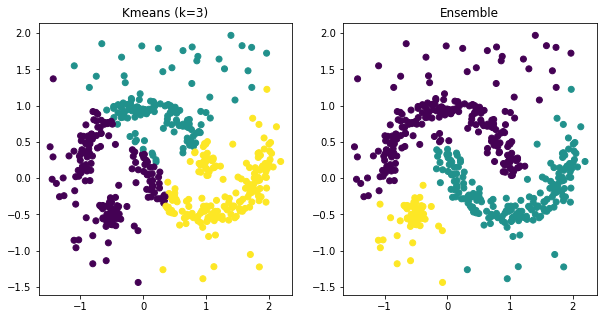

In [584]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(X_vectors[:,0], X_vectors[:,1], c=kmeans_preds);
ax[1].scatter(X_vectors[:,0], X_vectors[:,1], c=meta_preds);
ax[0].set_title("Kmeans (k=3)");
ax[1].set_title("Ensemble");

Reference: https://towardsdatascience.com/how-to-ensemble-clustering-algorithms-bf78d7602265

- I experimented and dropped the idea of thresholding as it only looses the information gained from our base learners.